In [1]:
from dataclasses import dataclass
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Dict, Any, Tuple

In [2]:
data_dir = "/home/lsy/shared_data/liuhaotian/LLaVA-CC3M-Pretrain-595K"
chat_file = Path(data_dir).joinpath("chat.json")
# 读取json文件
chat_data = pd.read_json(path_or_buf=chat_file)
chat_data.shape
chat_data.head(n=20)
# 将dataframe数据类型转换为字典
chat_data.to_dict(orient="records")

[{'id': 'GCC_train_002582585',
  'image': 'GCC_train_002582585.jpg',
  'conversations': [{'from': 'human',
    'value': 'Provide a brief description of the given image.\n<image>'},
   {'from': 'gpt',
    'value': 'olive oil is a healthy ingredient used liberally .'}]},
 {'id': 'GCC_train_002429825',
  'image': 'GCC_train_002429825.jpg',
  'conversations': [{'from': 'human',
    'value': '<image>\nWrite a terse but informative summary of the picture.'},
   {'from': 'gpt',
    'value': '3d vector deluxe alphabet of randomly rotated thin golden symbols .'}]},
 {'id': 'GCC_train_000190697',
  'image': 'GCC_train_000190697.jpg',
  'conversations': [{'from': 'human',
    'value': 'Share a concise interpretation of the image provided.\n<image>'},
   {'from': 'gpt',
    'value': 'weathering -- the physical & chemical breakdown of rocks .'}]},
 {'id': 'GCC_train_002503829',
  'image': 'GCC_train_002503829.jpg',
  'conversations': [{'from': 'human',
    'value': 'Relay a brief, clear account of 

In [3]:
class LlavaDataset(Dataset):
    def __init__(self, dataset_dir:str) -> None:
        super().__init__()
        self.chat_data, self.image_dir = self.build_dataset(dataset_dir)

    def build_dataset(self, data_dir:str) -> tuple[List[Dict[str, Any]], Path]:
        data_dir = Path(data_dir)
        chat_file = data_dir.joinpath("chat.json")
        image_dir = data_dir.joinpath("images_dl")
        chat_data = pd.read_json(path_or_buf=chat_file).to_dict(orient="records")
        return chat_data, image_dir
    
    def __len__(self) -> int:
        return len(self.chat_data)
    
    def __getitem__(self, index) -> tuple[str, str, Path]:
        cur_data = self.chat_data[index]
        human_input = cur_data['conversations'][0]['value']
        gpt_output = cur_data['conversations'][1]['value']
        image_path = self.image_dir.joinpath(cur_data.get('image'))

        return (human_input, gpt_output, image_path)

llava_dataset = LlavaDataset(dataset_dir=data_dir)

In [4]:
len(llava_dataset)
llava_dataset[12345]


('Describe the image concisely.\n<image>',
 'illustration of a gray goose on a white background',
 PosixPath('/home/lsy/shared_data/liuhaotian/LLaVA-CC3M-Pretrain-595K/images_dl/GCC_train_002160298.jpg'))

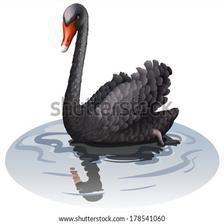

In [5]:
Image.open(llava_dataset[12345][2])

In [6]:
chat_data.iloc[10]['conversations']
chat_data.iloc[10]['image']
chat_data.iloc[10]

id                                             GCC_train_000177248
image                                      GCC_train_000177248.jpg
conversations    [{'from': 'human', 'value': '<image>
Provide a...
Name: 10, dtype: object

In [7]:
image_dir = Path(data_dir).joinpath("images_dl")
image_dir

PosixPath('/home/lsy/shared_data/liuhaotian/LLaVA-CC3M-Pretrain-595K/images_dl')

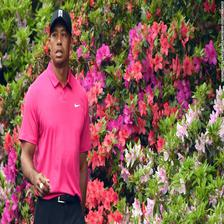

In [8]:
test_image_file = image_dir.joinpath(chat_data.iloc[10]['image'])
Image.open(fp=test_image_file)

### 读取模型权重并初始化

In [9]:
# huggingface transformers Trainer
# pytorch collator
from transformers import AutoProcessor
# 读取之前保存的Qwen4B + clip的llava架构
llava_model_name_or_path = "./show_model/model001"
llava_processor = AutoProcessor.from_pretrained(pretrained_model_name_or_path=llava_model_name_or_path)
llava_dataset[12345]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


('Describe the image concisely.\n<image>',
 'illustration of a gray goose on a white background',
 PosixPath('/home/lsy/shared_data/liuhaotian/LLaVA-CC3M-Pretrain-595K/images_dl/GCC_train_002160298.jpg'))

In [10]:
llava_processor

LlavaProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "LlavaProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

- tokenizer: Qwen2TokenizerFast(name_or_path='./show_model/model001', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<image>']}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=Fal

### 构建将数据转换为向量的处理类

In [11]:
from dataclasses import dataclass

@dataclass
class QaImageOutput:
    q_input_ids: torch.Tensor
    pixel_values: torch.Tensor
    a_input_ids: torch.Tensor

def build_qaimage(processor: AutoProcessor, q_text: str, a_text: str, image_path: Path) -> QaImageOutput:
    # instruction or input or question
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q_text},
    ]
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    # image
    raw_image = Image.open(fp=image_path)
    # 生成Question部分的向量
    inputs = processor(text=prompt, images=raw_image, return_tensors="pt")
    # 生成Answer部分的向量
    a_input_ids = processor.tokenizer(
        a_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
    )["input_ids"]
    return QaImageOutput(
        q_input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        a_input_ids=a_input_ids,
    )

c = build_qaimage(processor=llava_processor, q_text=llava_dataset[12345][0], a_text=llava_dataset[12345][1], image_path=llava_dataset[12345][2])
c

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


QaImageOutput(q_input_ids=tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
            285,    974,    624, 151646, 151645,    198, 151644,  77091,    198]]), pixel_values=tensor([[[[1.9011, 1.9011, 1.9011,  ..., 1.9011, 1.9011, 1.9011],
          [1.9011, 1.9011, 1.9011,  ..., 1.9011, 1.9011, 1.9011],
          [1.9157, 1.9157, 1.9157,  ..., 1.9157, 1.9157, 1.9157],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0449, 2.0449, 2.0449,  ..., 2.0449, 2.0449, 2.0449],
          [2.0449, 2.0449, 2.0449,  ..., 2.0449, 2.0449, 2.0449],
          [2.0599, 2.0599, 2.0599,  ..., 2.0599, 2.0599, 2.0599],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.07

In [12]:
c.q_input_ids, c.pixel_values, c.a_input_ids

(tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
          151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
             285,    974,    624, 151646, 151645,    198, 151644,  77091,    198]]),
 tensor([[[[1.9011, 1.9011, 1.9011,  ..., 1.9011, 1.9011, 1.9011],
           [1.9011, 1.9011, 1.9011,  ..., 1.9011, 1.9011, 1.9011],
           [1.9157, 1.9157, 1.9157,  ..., 1.9157, 1.9157, 1.9157],
           ...,
           [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
           [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
           [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],
 
          [[2.0449, 2.0449, 2.0449,  ..., 2.0449, 2.0449, 2.0449],
           [2.0449, 2.0449, 2.0449,  ..., 2.0449, 2.0449, 2.0449],
           [2.0599, 2.0599, 2.0599,  ..., 2.0599, 2.0599, 2.0599],
           ...,
           [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
           [2.0749, 2.0749, 2.0749,  ..., 2.07

In [13]:
c.q_input_ids.shape, c.pixel_values.shape, c.a_input_ids.shape

(torch.Size([1, 27]), torch.Size([1, 3, 336, 336]), torch.Size([1, 10]))

### 测试对于文本token的解码

In [14]:
llava_processor.decode(c.q_input_ids[0])

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nDescribe the image concisely.\n<image><|im_end|>\n<|im_start|>assistant\n'

In [15]:
# torch.tensor(llava_processor.tokenizer.eos_token_id)
torch.tensor(llava_processor.tokenizer.eos_token_id).reshape(1, -1)

tensor([[151645]])

### 定义`collator`函数

In [16]:
from torch import Tensor
# 定义 collator 函数
class TrainLLavaModelCollator:
    def __init__(self, processor: AutoProcessor, IGNORE_INDEX: int) -> None:
        self.processor = processor
        self.ignore_index = IGNORE_INDEX
    
    # 拼接单个样本的 q_input_ids 及 a_input_ids
    def convert_one_piece(self,
                          q_input_ids: torch.Tensor,
                          a_input_ids: torch.Tensor) -> None:
        input_ids = torch.concat(tensors=[
            q_input_ids,
            a_input_ids,
            torch.tensor(data=self.processor.tokenizer.eos_token_id).reshape(1, -1)
        ], axis=1)
        labels = torch.concat([
            torch.full_like(input=q_input_ids, fill_value=self.ignore_index),
            a_input_ids,
            torch.tensor(data=self.processor.tokenizer.eos_token_id).reshape(1, -1)
        ], axis=1)
        return input_ids, labels
    
    def __call__(self, features:List) -> tuple[Tensor, Tensor, Tensor, Tensor]:
        input_ids_list = []
        labels_list = []
        pixel_values = []
        max_input_len_list = []

        for feature in features:
            # 1. 调用 build_qaimage 函数将单个样本转换为张量
            qaimage_output = build_qaimage(
                processor=self.processor,
                q_text=feature[0],
                a_text=feature[1],
                image_path=feature[2]
            )
            # 2. 将单个样本的 q_input_ids 及 a_input_ids 张量拼接
            temp_input_ids, temp_labels = self.convert_one_piece(
                q_input_ids=qaimage_output.q_input_ids,
                a_input_ids=qaimage_output.a_input_ids
            )
            input_ids_list.append(temp_input_ids)
            labels_list.append(temp_labels)
            pixel_values.append(qaimage_output.pixel_values)
            max_input_len_list.append(temp_input_ids.shape[1])
        
        # 对齐 input_ids 和 labels
        max_input_len = max(max_input_len_list)
        final_input_ids = torch.concat([    # 将所有对齐到最大长度后的 input_ids 拼接起来组成 final_input_ids
            torch.concat([  # 遍历每个 input_ids 将它们对齐到最大长度
                torch.full(size=(1, max_input_len - max_input_len_list[index]), fill_value=self.processor.tokenizer.pad_token_id),
                value
            ], axis=1)
            for index, value in enumerate(iterable=input_ids_list)
        ])

        final_labels = torch.concat([    # 将所有对齐到最大长度后的 labels 拼接起来组成 final_labels
            torch.concat([  # 遍历每个 labels 将它们对齐到最大长度
                torch.full(size=(1, max_input_len - max_input_len_list[index]), fill_value=self.ignore_index),
                value
            ], axis=1)
            for index, value in enumerate(iterable=labels_list)
        ])

        # 按照 dim=0 维拼接所有的 pixel_values
        final_pixel_values = torch.concat(pixel_values, axis=0)
        attention_mask = torch.ones_like(final_input_ids)
        # 因对齐而造成的填充部分 attention_mask 置 0
        attention_mask[final_input_ids == self.processor.tokenizer.pad_token_id] = 0
        return {
            "input_ids": final_input_ids,
            "labels": final_labels,
            "pixel_values": final_pixel_values,
            "attention_mask": attention_mask
        }

tlmc = TrainLLavaModelCollator(llava_processor, -100)
tlmc.convert_one_piece(c.q_input_ids, c.a_input_ids)

(tensor([[151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
          151645,    198, 151644,    872,    198,  74785,    279,   2168,   3529,
             285,    974,    624, 151646, 151645,    198, 151644,  77091,    198,
           82618,    367,    315,    264,  17545,  62137,    389,    264,   4158,
            4004, 151645]]),
 tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
            -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
            -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           82618,    367,    315,    264,  17545,  62137,    389,    264,   4158,
            4004, 151645]]))

In [17]:
d = tlmc([llava_dataset[1], llava_dataset[100]])
d['input_ids'].shape, d['labels'].shape, d['pixel_values'].shape, d['attention_mask'].shape

(torch.Size([2, 54]),
 torch.Size([2, 54]),
 torch.Size([2, 3, 336, 336]),
 torch.Size([2, 54]))

In [18]:
d['attention_mask']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])

In [19]:
d['input_ids']

tensor([[151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643, 151644,   8948,    198,   2610,    525,    264,  10950,  17847,
             13, 151645,    198, 151644,    872,    198, 151646,    198,   7985,
            264,  50537,    714,  38219,  12126,    315,    279,   6802,     13,
         151645,    198, 151644,  77091,    198,     18,     67,   4621,  78424,
          27790,    315,  26618,  45620,  15430,  20748,  17738,    659, 151645],
        [151644,   8948,    198,   2610,    525,    264,  10950,  17847,     13,
         151645,    198, 151644,    872,    198,   6740,    352,    264,   9814,
             11,   2797,   2692,    315,    279,   6802,   6839,    624, 151646,
         151645,    198, 151644,  77091,    198,    266,   2544,  54236,   1293,
           1154,    419,  44486,    481,  11466,    572,     79,   1231,    387,
            825,    315,    279,  24632,  40811,    304,    279,   1879, 151645]])

In [20]:
d['labels']

tensor([[  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,     18,     67,   4621,  78424,
          27790,    315,  26618,  45620,  15430,  20748,  17738,    659, 151645],
        [  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,    266,   2544,  54236,   1293,
           1154,    419,  44486,    481,  11466,    572,     79,   1231,    387,
            825,    315,    279,  24632,  40811,    304,    279,   1879, 151645]])

In [21]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
llava_model_name_or_path = "./show_model/model001"
llava_model = LlavaForConditionalGeneration.from_pretrained(pretrained_model_name_or_path=llava_model_name_or_path,
                                                            torch_dtype=torch.bfloat16,
                                                            device_map='cuda:0')

<class 'transformers.models.llava.configuration_llava.LlavaConfig'>


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
for tk in d.keys():
    d[tk] = d[tk].to(device='cuda:0')
model_output = llava_model(**d)

0.0
9.369547843933105


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.


3.0097484588623047 9.369547843933105 {'corr': 0.4703010265064023, 'p': 0.3564356565475464, 'id': 7.972788333892822, 'id1': 3.0097484588623047, 'id2': 9.369547843933105}


In [23]:
model_output

LlavaCausalLMOutputWithPast(loss=tensor(9.0625, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<NllLossBackward0>), logits=tensor([[[-1.3203, -1.4141, -4.1562,  ...,  1.3203,  1.3281,  1.3203],
         [-1.3203, -1.4141, -4.1562,  ...,  1.3203,  1.3281,  1.3203],
         [-1.3203, -1.4141, -4.1562,  ...,  1.3203,  1.3281,  1.3203],
         ...,
         [ 3.2188,  2.9844, -1.2031,  ..., -3.8750, -3.8750, -3.8750],
         [ 2.1875, -0.2520,  0.9609,  ..., -3.0781, -3.0938, -3.0781],
         [-1.5391,  2.5156, -2.5312,  ..., -0.8906, -0.8867, -0.8867]],

        [[ 0.1846, -0.2988, -1.2344,  ...,  0.2217,  0.2256,  0.2256],
         [ 0.3945, -0.1396, -1.0391,  ..., -0.3340, -0.3281, -0.3301],
         [ 2.1406,  3.2500, -0.7930,  ..., -5.5625, -5.5625, -5.5625],
         ...,
         [ 2.0469,  2.4688, -1.7500,  ..., -3.9219, -3.9062, -3.9219],
         [ 5.3438,  4.6562, -0.2969,  ..., -4.9062, -4.9062, -4.9062],
         [-2.6094,  1.6094, -3.9375,  ..., -0.8438, -0.8398